In [15]:
from ngboost import NGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from datetime import datetime as dt
import numpy as np
from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
import matplotlib.pyplot as plt

In [16]:
train_data = pd.read_csv('df_trainNP.csv', parse_dates=['Date'])
test_data = pd.read_csv('df_testNP30.csv', parse_dates=['Date'])
#test_data1 = pd.read_csv('df_test_f.csv', parse_dates=['Date'])
train_data

,Date,Price,Exogenous 1,Exogenous 2
0,2013-01-01 00:00:00,31.05,42497.0,2798.0
1,2013-01-01 01:00:00,30.47,41463.0,2417.0
2,2013-01-01 02:00:00,28.92,40812.0,2036.0
3,2013-01-01 03:00:00,27.88,40246.0,1706.0
4,2013-01-01 04:00:00,26.96,40088.0,1427.0
...,...,...,...,...
43675,2017-12-25 19:00:00,26.97,48246.0,3825.0
43676,2017-12-25 20:00:00,26.27,47461.0,3795.0
43677,2017-12-25 21:00:00,26.05,46953.0,3814.0
43678,2017-12-25 22:00:00,25.84,45571.0,3791.0


In [17]:
# Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=test_data.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = test_data.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [18]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
0,25.82,24.94,23.81,23.68,24.29,25.04,25.26,25.79,25.77,26.34,...,25.86,26.32,27.24,27.15,26.97,26.42,26.08,25.93,25.21,24.51
24,25.26,24.22,22.73,22.45,24.23,25.71,26.44,28.23,29.74,30.08,...,35.05,37.12,38.67,39.16,37.78,33.94,31.32,30.37,29.38,28.22
48,28.81,28.06,27.12,26.36,27.13,28.78,30.65,32.78,35.75,36.76,...,35.66,36.73,37.04,36.76,35.03,30.93,29.03,28.28,27.47,26.82
72,26.33,25.63,25.38,25.44,26.03,26.83,27.26,27.94,29.17,30.08,...,30.13,31.37,33.02,34.10,32.12,29.81,28.49,27.73,26.90,26.68
96,27.30,26.86,26.39,26.06,26.06,26.37,26.79,26.71,26.95,27.35,...,27.34,27.51,27.84,27.93,27.65,27.34,26.55,26.23,25.96,25.59
120,26.98,26.44,26.20,25.90,25.37,25.49,25.97,26.01,26.38,26.97,...,27.39,27.66,27.98,27.92,27.56,26.75,26.08,25.83,25.78,25.43
144,26.31,26.43,26.09,24.63,24.67,24.24,24.18,24.29,24.15,24.26,...,26.03,26.43,27.02,27.43,27.30,26.97,26.69,26.45,26.07,25.02
168,25.74,25.13,25.40,25.49,25.66,26.75,27.69,30.73,33.77,34.04,...,36.02,38.06,41.68,42.40,39.05,35.02,30.88,28.81,27.95,27.55
192,27.05,26.52,25.96,25.52,25.80,26.68,27.65,28.52,28.83,28.89,...,29.85,30.50,31.11,31.43,30.78,30.14,29.37,28.93,28.12,27.31
216,27.05,26.78,26.47,26.49,26.59,26.97,28.02,30.59,33.44,35.49,...,35.93,38.03,39.71,39.03,37.23,32.90,30.98,30.49,29.72,28.07


In [21]:
len(real_values)

31

In [22]:
train_data['day'] = train_data['Date'].apply(lambda x: x.day)
train_data['month'] = train_data['Date'].apply(lambda x: x.month)
train_data['year'] = train_data['Date'].apply(lambda x: x.year)
train_data['hour'] = train_data['Date'].apply(lambda x: x.hour)
#train_data['minute'] = train_data['Date'].apply(lambda x: x.day)

train_data['day_of_year'] = train_data['Date'].apply(lambda x: x.day_of_year)
train_data['week_day'] = train_data['Date'].apply(lambda x: x.weekday())
train_data['week_of_year'] = train_data['Date'].apply(lambda x: x.week)

test_data['day'] = test_data['Date'].apply(lambda x: x.day)
test_data['month'] = test_data['Date'].apply(lambda x: x.month)
test_data['year'] = test_data['Date'].apply(lambda x: x.year)
test_data['hour'] = test_data['Date'].apply(lambda x: x.hour)
#test_data['minute'] = test_data['Date'].apply(lambda x: x.day)

test_data['day_of_year'] = test_data['Date'].apply(lambda x: x.day_of_year)
test_data['week_day'] = test_data['Date'].apply(lambda x: x.weekday())
test_data['week_of_year'] = test_data['Date'].apply(lambda x: x.week)

#converting the date into ng boost acceptable format

In [23]:
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

In [24]:
cols=['h0_m','h0_sd','h1_m','h1_sd','h2_m','h2_sd','h3_m','h3_sd','h4_m','h4_sd','h5_m','h5_sd','h6_m','h6_sd',
        'h7_m','h7_sd','h8_m','h8_sd','h9_m','h9_sd','h10_m','h10_sd','h11_m','h11_sd','h12_m','h12_sd','h13_m','h13_sd',
        'h14_m','h14_sd','h15_m','h15_sd','h16_m','h16_sd','h17_m','h17_sd','h18_m','h18_sd','h19_m','h19_sd',
         'h20_m','h20_sd','h21_m','h21_sd','h22_m','h22_sd','h23_m','h23_sd']

forecast_ng_NP = pd.DataFrame(index=test_data.index[::24], columns=cols)

#forecast_ng_NP = pd.DataFrame(index=test_data.index[::24], columns=['m_h' + str(k) for k in range()])



# frame for h0, h1, h2... h24
real_values= test_data.loc[:, ['Price']].values.reshape(-1, 24)
# to the location
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)
#inserting the forecasted values into the dataframe

In [25]:
forecast_ng_NP

,h0_m,h0_sd,h1_m,h1_sd,h2_m,h2_sd,h3_m,h3_sd,h4_m,h4_sd,...,h19_m,h19_sd,h20_m,h20_sd,h21_m,h21_sd,h22_m,h22_sd,h23_m,h23_sd
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
real_values.head()

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
0,25.82,24.94,23.81,23.68,24.29,25.04,25.26,25.79,25.77,26.34,...,25.86,26.32,27.24,27.15,26.97,26.42,26.08,25.93,25.21,24.51
24,25.26,24.22,22.73,22.45,24.23,25.71,26.44,28.23,29.74,30.08,...,35.05,37.12,38.67,39.16,37.78,33.94,31.32,30.37,29.38,28.22
48,28.81,28.06,27.12,26.36,27.13,28.78,30.65,32.78,35.75,36.76,...,35.66,36.73,37.04,36.76,35.03,30.93,29.03,28.28,27.47,26.82
72,26.33,25.63,25.38,25.44,26.03,26.83,27.26,27.94,29.17,30.08,...,30.13,31.37,33.02,34.10,32.12,29.81,28.49,27.73,26.90,26.68
96,27.30,26.86,26.39,26.06,26.06,26.37,26.79,26.71,26.95,27.35,...,27.34,27.51,27.84,27.93,27.65,27.34,26.55,26.23,25.96,25.59


In [27]:
real_values.index = forecast_ng_NP.index

In [28]:
real_values.head()

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,25.82,24.94,23.81,23.68,24.29,25.04,25.26,25.79,25.77,26.34,...,25.86,26.32,27.24,27.15,26.97,26.42,26.08,25.93,25.21,24.51
2017-12-27,25.26,24.22,22.73,22.45,24.23,25.71,26.44,28.23,29.74,30.08,...,35.05,37.12,38.67,39.16,37.78,33.94,31.32,30.37,29.38,28.22
2017-12-28,28.81,28.06,27.12,26.36,27.13,28.78,30.65,32.78,35.75,36.76,...,35.66,36.73,37.04,36.76,35.03,30.93,29.03,28.28,27.47,26.82
2017-12-29,26.33,25.63,25.38,25.44,26.03,26.83,27.26,27.94,29.17,30.08,...,30.13,31.37,33.02,34.10,32.12,29.81,28.49,27.73,26.90,26.68
2017-12-30,27.30,26.86,26.39,26.06,26.06,26.37,26.79,26.71,26.95,27.35,...,27.34,27.51,27.84,27.93,27.65,27.34,26.55,26.23,25.96,25.59


In [29]:
forecast_dates_ng_NP = forecast_ng_NP.index

In [30]:
len(forecast_dates_ng_NP)

31

In [32]:
len(real_values)

31

In [33]:
X_train = train_data.drop('Price', axis=1)
y_train = train_data['Price']

X_test = test_data.drop('Price', axis=1)
y_test = test_data['Price']


In [34]:
forecast_ng_NP.head()

,h0_m,h0_sd,h1_m,h1_sd,h2_m,h2_sd,h3_m,h3_sd,h4_m,h4_sd,...,h19_m,h19_sd,h20_m,h20_sd,h21_m,h21_sd,h22_m,h22_sd,h23_m,h23_sd
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#loop over each date:


for date in forecast_dates_ng_NP:
    
    print(date)

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([train_data, test_data.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    #Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
    #                                             calibration_window=365)
    
    X_train = data_available.loc[train_data.index.values].drop('Price', axis=1)
    y_train = data_available.loc[train_data.index.values]['Price']
    
    X_test = data_available.loc[date:date + pd.Timedelta(hours=23)].drop('Price', axis=1)
    y_test = data_available.loc[date:date + pd.Timedelta(hours=23), 'Price']
    
    #print(y_test)

    print("training ngboost")
    ngb = NGBRegressor()#learning_rate=0.09, n_estimators=800)
    ngb.fit(X_train, y_train)
    print("ngboost trained")
    
    ## train the NgBoost model
    ## make a prediction for the 24 hours over the "date"
    ## model.fit(X_train, y_train)
    
    #get out t he predicted price at each hour in the "date"
    
    y0_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[0]).T)
    y1_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[1]).T)
    y2_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[2]).T)
    y3_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[3]).T)
    y4_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[4]).T)
    y5_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[5]).T)
    y6_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[6]).T)
    y7_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[7]).T)
    y8_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[8]).T)
    y9_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[9]).T)
    y10_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[10]).T)
    y11_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[11]).T)
    y12_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[12]).T)
    y13_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[13]).T)
    y14_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[14]).T)
    y15_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[15]).T)
    y16_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[16]).T)
    y17_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[17]).T)
    y18_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[18]).T)
    y19_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[19]).T)
    y20_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[20]).T)
    y21_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[21]).T)
    y22_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[22]).T)
    y23_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[23]).T)
    
    print("y0_dist")
    y0_mean = y0_dist.loc[0]
    y0_sd = y0_dist.scale[0]
    print(y0_mean,y0_sd)
    
    y1_mean = y1_dist.loc[0]
    y1_sd = y1_dist.scale[0]
    print(y1_mean,y1_sd)
    
    y2_mean = y2_dist.loc[0]
    y2_sd = y2_dist.scale[0]
    print(y2_mean,y2_sd)
    
    y3_mean = y3_dist.loc[0]
    y3_sd = y3_dist.scale[0]
    print(y3_mean,y3_sd)
    
    y4_mean = y4_dist.loc[0]
    y4_sd = y4_dist.scale[0]
    print(y4_mean,y4_sd)
   
    y5_mean = y5_dist.loc[0]
    y5_sd = y5_dist.scale[0]
    print(y5_mean,y5_sd)
    
    y6_mean = y6_dist.loc[0]
    y6_sd = y6_dist.scale[0]
    print(y6_mean,y6_sd)
    
    y7_mean = y7_dist.loc[0]
    y7_sd = y7_dist.scale[0]
    print(y7_mean,y7_sd)
    
    y8_mean = y8_dist.loc[0]
    y8_sd = y8_dist.scale[0]
    print(y8_mean,y8_sd)
    
    y9_mean = y9_dist.loc[0]
    y9_sd = y9_dist.scale[0]
    print(y9_mean,y9_sd)
    
    y10_mean = y10_dist.loc[0]
    y10_sd = y10_dist.scale[0]
    print(y10_mean,y10_sd)
    
    y11_mean = y11_dist.loc[0]
    y11_sd = y11_dist.scale[0]
    print(y11_mean,y11_sd)
    
    y12_mean = y12_dist.loc[0]
    y12_sd = y12_dist.scale[0]
    print(y12_mean,y12_sd)
    
    y13_mean = y13_dist.loc[0]
    y13_sd = y13_dist.scale[0]
    print(y13_mean,y13_sd)
    
    
    y14_mean = y14_dist.loc[0]
    y14_sd = y14_dist.scale[0]
    print(y14_mean,y14_sd)
    
    y15_mean = y15_dist.loc[0]
    y15_sd = y15_dist.scale[0]
    print(y15_mean,y15_sd)
    
    y16_mean = y16_dist.loc[0]
    y16_sd = y16_dist.scale[0]
    print(y16_mean,y16_sd)
    
    y17_mean = y17_dist.loc[0]
    y17_sd = y17_dist.scale[0]
    print(y17_mean,y17_sd)
    
    y18_mean = y18_dist.loc[0]
    y18_sd = y18_dist.scale[0]
    print(y18_mean,y18_sd)
    
    y19_mean = y19_dist.loc[0]
    y19_sd = y19_dist.scale[0]
    print(y19_mean,y19_sd)
    
    y20_mean = y20_dist.loc[0]
    y20_sd = y20_dist.scale[0]
    print(y20_mean,y20_sd)
    
    y21_mean = y21_dist.loc[0]
    y21_sd = y21_dist.scale[0]
    print(y21_mean,y21_sd)
    
    y22_mean = y22_dist.loc[0]
    y22_sd = y22_dist.scale[0]
    print(y22_mean,y22_sd)
    
    y23_mean = y23_dist.loc[0]
    y23_sd = y23_dist.scale[0]
    print(y23_mean,y23_sd)
    
    
    #put the values y0,...y23 into an array Yp
    
    Yp = [y0_mean, y0_sd, y1_mean, y1_sd, y2_mean, y2_sd, y3_mean, y3_sd, y4_mean, y4_sd, y5_mean, y5_sd, y6_mean, y6_sd, 
          y7_mean, y7_sd, y8_mean, y8_sd, y9_mean, y9_sd, y10_mean, y10_sd, y11_mean, y11_sd, y12_mean, y12_sd, 
          y13_mean, y13_sd, y14_mean, y14_sd, y15_mean, y15_sd, y16_mean, y16_sd, y17_mean, y17_sd, y18_mean, y18_sd, 
          y19_mean, y19_sd, y20_mean, y20_sd, y21_mean, y21_sd, y22_mean, y22_sd, y23_mean, y23_sd]
         
    # Saving the current prediction
    forecast_ng_NP.loc[date, :] = Yp
    
    print(Yp)

    #foreacsting 24 hours price for 30 days using NG booster
    

2017-12-26 00:00:00
training ngboost
[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136


C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
23.309600496528105 3.2969349886630313
23.37788854407479 3.2969349886630313
23.37788854407479 3.2969349886630313
23.37788854407479 3.2969349886630313
23.37788854407479 3.2969349886630313
23.612729938366588 3.2969349886630313
24.19558279483654 3.306554310556825
24.598461642540535 3.3089597499668666
25.176158847976836 3.1430224828640663
25.29089008531338 3.171292088472061
25.33970107782563 3.1278026778624475
25.28894333886644 2.791636300896647
25.28894333886644 2.753895177508502
25.28894333886644 2.753895177508502
25.28894333886644 2.753895177508502
25.840641167363216 2.7345793431238117
25.97547832374022 2.7496430901727247
25.973116730815914 2.7496430901727247
25.840641167363216 2.7345793431238117
25.5314106679825

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
24.129148531348633 3.290781535261471
24.542418537924803 3.268888005364521
26.349567714233512 3.0851875389794734
27.309616367309005 3.048296657512984
27.648202469409608 2.9559397369916987
28.24267722149985 2.850518778015182
29.189210266033722 2.8096558883980665
30.67432156345277 3.343360813352401
31.307622691769204 3.343360813352401
31.307622691769204 3.343360813352401
31.521608352900788 3.2975117438969197
31.54929989321208 2.7807756817391334
31.498242304370464 2.7432774185778057
31.47125416280626 2.7432774185778057
31.598060864844662 2.7432774185778057
32.541488723354064 3.083039186946971
33.25341912654011 3.478294246629203
33.28040726810431 3.478294246629203
33.42359747262657 3.083039186946971
32.6808156176845

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
30.16143933676568 2.942125198886207
30.367585711733092 2.942125198886207
30.37627393950863 2.942125198886207
30.41069009047106 2.942125198886207
30.402001862695524 2.942125198886207
30.45166677164445 2.942125198886207
31.6434513179955 2.924831332032582
33.14186172395384 3.4845712185144775
33.280950114278795 3.4845712185144775
33.35899584468461 3.4845712185144775
33.73967861729748 3.4367856647740047
33.586551098518385 2.8982247046250293
33.19041674092138 2.859142662377478
33.19041674092138 2.859142662377478
33.68892087833828 2.859142662377478
34.043019132678154 3.5474893617216368
34.8445059069872 4.624692577862376
34.13552787581262 4.413548726774242
32.541488723354064 3.3700641786401437
31.549299893212083 2.8274

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
27.17228099730456 3.135005565327763
27.153587714593627 3.135005565327763
26.839709177706336 3.1615864189000837
26.92640701590948 3.135005565327763
26.90182096554164 3.135005565327763
26.50524878711302 3.1729458092414404
27.664623940079576 3.1135690508971994
28.988864500816025 3.4291761769811484
30.117343045136753 3.4291761769811484
30.117343045136753 3.4291761769811484
30.30638044558456 3.3883764509526353
30.273025368107408 2.857401449085235
30.19497963770159 2.818869901143782
30.462800612397686 2.818869901143782
30.556921030362417 2.818869901143782
31.562486395548483 2.818869901143782
32.23699014736397 3.3598897678026542
32.23699014736397 3.3598897678026542
32.21526754180722 2.818869901143782
31.16675558681615

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
27.958706546087654 2.931601886950144
27.966468076618057 2.931601886950144
27.966468076618057 2.931601886950144
27.518125795424414 3.0400215488879065
27.400362629692268 3.1350055653277606
27.36900043869541 3.1350055653277606
27.242529205039084 3.0873919005481003
27.968683219735112 3.083960669452181
28.32921542021 3.0781498397221134
28.94687781500889 3.229879794346706
29.67352738047119 3.388376450952632
29.64216518947433 2.857401449085233
29.405706405775092 2.8188699011437803
29.294714735733105 2.8188699011437803
29.294714735733105 2.8188699011437803
29.139700346527736 2.8188699011437803
29.36887682838603 2.8188699011437803
29.36887682838603 3.359889767802652
29.0173407304568 2.8188699011437803
28.78816424859851 

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
29.04759626152308 2.9316018869501472
29.07123900929049 2.9316018869501472
29.37170520498529 2.9316018869501472
29.37170520498529 2.9316018869501472
29.776845885001723 2.9316018869501472
29.87142698027851 2.935579740540438
29.132687981317446 2.9316018869501472
29.65890507585416 3.110635962385087
29.40305617700266 3.0839606694521846
28.937322334722264 3.078149839722117
28.838468132075395 3.191451261103372
28.03165812425815 2.866801902193843
25.942165386712183 2.8281435908220214
25.648113537655025 2.8281435908220214
25.328110548584636 2.8281435908220214
25.683779883177078 2.818869901143781
26.399567354740462 2.818869901143781
26.669474239096132 2.818869901143781
27.663361929292815 2.818869901143781
27.786929849512

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
27.550490632455695 2.347208457785082
27.699166537531614 2.276093022071744
27.60487076820965 2.347208457785082
27.500562520814388 2.347208457785082
27.06136042578425 2.377753623504725
27.082349673440717 2.377753623504725
27.08814048585183 2.377753623504725
27.50710755873179 2.379483382563903
27.2340982523103 2.379483382563903
27.176698798404672 2.379483382563903
27.542478637209896 2.493473898299384
27.3157491660761 2.2541726582825072
27.330554043875708 2.2032308404401175
26.991325766849286 2.2032308404401175
26.95056272414281 2.2032308404401175
27.515070951350943 2.2323443518052186
27.474791527937526 2.2323443518052186
28.259857574778398 2.2323670655045973
28.451101956333122 2.2323443518052186
28.51667579369599 

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
27.593153710774562 2.326126988830073
27.687975559769665 2.326126988830073
27.663545245552758 2.326126988830073
27.73398434235972 2.1752045180267325
27.62092972926265 2.1752045180267325
28.08430591483446 2.2295044854339285
28.824360986662406 2.2312807821642506
29.44569430613393 2.4810082615225273
29.880637273147244 2.453468911873171
29.9278680637692 2.6611500023410546
29.9278680637692 2.6246564085890713
29.904038440113244 2.6372579397702767
29.92017792094671 2.6179007519452573
29.904038440113244 2.588841886937332
29.904038440113244 2.588841886937332
30.797572940616398 2.9260919865771426
32.796701638237785 3.091960922282842
33.27159708405379 3.0576399592044536
30.4320237846869 2.998241917520059
29.598750114361145

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
27.060202970332256 2.3084221866859114
26.440485356076973 2.3084221866859114
26.225892440844966 2.465402225044828
25.857847368327963 2.4997535457464304
25.65422042971309 2.4997535457464304
25.91953343369814 2.4658241005765524
26.871107745538925 2.423822902627626
27.429039808432414 2.403516944137044
27.531409588252302 2.714627611712624
28.522182092809157 2.8160615831207605
28.546327057510645 2.9880669026228492
29.58982426375976 2.8877130412065783
29.82373541930076 2.8346990128625698
30.001239556791376 2.6348863424969204
30.08841851588456 2.8346990128625698
30.41030117913016 2.995387231300816
32.24584033256958 3.0580381570993524
33.77314728298895 3.0580381570993524
31.958263065473172 3.0290094287938456
29.92972829

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.22872480801277 2.2144731704424383
28.081170389452865 2.2144731704424383
27.97715397148558 2.2144731704424383
27.97715397148558 2.2144731704424383
28.046352584624756 2.2963712049533225
28.670957608652095 2.427235974807893
29.814281227047687 2.503501130668355
31.636717649750512 2.7356891310328186
32.596351196963255 3.368404998938792
32.64741232735512 3.368404998938792
33.23158707038388 3.560889282238112
33.668765320913366 3.4787402051313885
33.668765320913366 3.1175339899741736
33.668765320913366 3.1175339899741736
33.668765320913366 3.353947523812641
35.280014861635294 3.5142306505863736
37.5397565643475 4.940192123010938
37.973315619710064 5.055877540182562
36.961498595748466 5.087293008255447
34.71415671287

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
29.452333448361216 3.074718460605522
29.320900442433523 2.9669367191416027
29.320900442433523 2.9669367191416027
29.320900442433523 2.9669367191416027
29.452333448361216 2.9669367191416027
30.595942270660576 3.1205395322006786
32.9835032011585 3.6493125823967203
35.36202427908486 4.940131897693369
39.40231923465225 6.978840596541066
39.40231923465225 6.827696222053296
40.03926781334538 7.172569703887235
39.988510074386184 6.526326231704459
39.351561495693055 6.1799910015680695
36.60179483731963 5.828043787374615
36.9944577760932 6.755449127669241
40.039854550035336 8.39585650691877
41.268917168694145 10.156979477140442
41.47780101137991 10.086700886311068
40.039854550035336 8.438543948155507
36.33097330446588 5

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
30.063356991086703 2.850096004631519
29.253610478896437 2.850096004631519
29.202234743110587 2.7501882196897887
29.122177472968744 2.7501882196897887
29.253610478896437 2.7501882196897887
29.807508037565373 2.850096004631519
31.075391341314717 2.850096004631519
32.02632873737803 3.4027298184011263
32.92334596958837 3.573810841804488
33.29186920206467 3.5490827825996787
34.30099112239661 3.5121801805599056
34.541126086763775 3.9401012392691186
34.48978161111462 3.516654225301834
34.179040140950704 2.9056188890326435
34.269063709804705 3.095999854050387
34.59719014202532 3.6677642557486743
36.86149393226761 4.4602681109388875
38.568946781407874 5.35330292098846
37.649003360859915 4.9351248511654395
34.69795553797

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
30.09583761328382 2.776886428401032
29.960029194198114 2.7835983998303213
29.596456432998018 2.7835983998303213
29.630872583960446 2.7835983998303213
30.011373669847266 2.7835983998303213
30.011373669847266 2.7835983998303213
30.106364242927132 2.7835983998303213
31.000486945836194 3.3233383233982963
31.59408826341292 3.5490827825996787
32.266027410522824 3.5490827825996787
32.34407314092864 3.491513423637506
32.9437484309926 2.9332741928553396
32.39283411256123 2.894410470956541
32.37590578787451 2.894410470956541
32.34148963691207 2.894410470956541
33.27923833309035 3.3825454333441223
34.29100359246574 3.940556788220153
35.96316456299881 5.137282204052289
34.27934393006456 3.940556788220153
33.15790630269553 

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
30.019113417444405 2.9002232215165202
29.792974915014078 2.8979143874752094
29.804634577415253 2.8979143874752094
29.973824711816647 2.9018465309227506
30.321447198062025 2.928224378500742
31.903416781822084 3.424409772180502
35.13136166128626 4.476757148138122
43.56842782111627 13.50861139238007
46.98563026725766 16.68603753700767
44.01449734552254 16.217570530363666
44.01449734552254 15.489717983661913
43.51767008215708 12.069896412602201
42.07474343594933 10.414913807732894
41.96051596437471 9.861310586161554
41.96051596437471 10.365570769012743
43.51767008215708 10.992072543150396
45.43146604644578 9.09494248975701
46.16882123978922 8.259915440391424
41.9040892533714 7.980522088816959
38.73199601690221 5.55

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
31.152728234808198 3.039565281147349
30.523835129105567 3.033702827210126
30.225392561646768 3.033702827210126
30.37533796586272 3.033702827210126
30.251450186551573 3.033702827210126
30.460814427586868 3.4803344793551214
31.85379760095139 3.7968975358556585
35.990990823121756 5.627901942975882
37.19817812495871 5.841767800204132
36.88521526638775 5.81676900016028
37.19817812495871 5.714132508074808
36.84414659003631 5.109577318606076
36.69212678178499 5.054683075189458
35.80050063397528 4.915395545608577
35.80050063397528 4.915395545608577
36.80796213200118 5.047753481616005
37.17569061306686 5.115560749154842
37.17569061306686 5.115560749154842
37.120924990572135 5.050802654877924
35.80050063397528 4.91539554

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
30.37735917467299 3.132601480243968
30.16052933201059 3.1002732185149644
30.425836860007767 3.0717605109156603
30.73026185267914 3.074207852101794
30.810435036188252 2.9810658773656065
32.20369965987451 3.3259413983339705
34.46684299917537 3.628461222518617
39.695919869369014 6.0945808397584775
41.49536449608223 7.0893826073713075
40.72510397295167 7.059044862993681
43.23826343338595 7.439847497972588
43.750074431420806 6.731449866641377
44.00535178779693 7.3416620412298
42.678260491805354 7.139354210347193
43.154473317736674 7.139354210347193
44.21140346339797 7.978847055103337
45.687380684168524 8.220466245419056
47.12956411016186 8.258181764739588
44.6258341578493 8.015454024985369
43.48411894129182 6.771617

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
33.563763479411534 3.728764282669802
33.07690341468236 3.6873458641486736
33.07690341468236 3.6873458641486736
33.07690341468236 3.6873458641486736
33.30304191711269 3.690283656131083
34.45033408140113 4.041099574756916
37.2807898971245 4.87856271045947
45.44192601590214 12.897910466931188
48.122019241202246 15.655766567624168
47.351758718071686 16.199544734145967
47.351758718071686 15.907489394822084
47.30100097911249 14.474235818401727
46.83248704450913 12.75508186436057
45.50539574851758 10.793662498269097
45.488467423830855 9.663332418953793
47.249656503463335 10.937096015522076
48.23176325581684 10.735091571086896
49.67394668181017 10.735091571086896
47.526046558176844 10.370585974850092
44.70145159822762 

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
32.899955999923925 2.7322467027835375
32.438576446275114 2.713929905151138
32.157818256397796 2.713929905151138
31.880740880143765 2.713929905151138
32.10687938257409 2.713929905151138
33.07366400323513 2.8720612912242194
35.20025194994412 3.265549341764232
39.969643173026526 5.469932539797129
41.699765728040106 5.80460272651456
41.699765728040106 5.80460272651456
41.699765728040106 5.677779444584814
41.83454415327615 4.984953929476131
41.24245506013605 5.204511756094117
40.234993562110176 5.051982833645
39.94259466054507 4.7255313920507085
40.056822132119706 4.776284990584315
41.029670322378955 4.923462371242295
41.73538702001895 5.017471605559314
40.143574449032215 4.920490073402871
38.66512767133608 4.378293

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.015168847322503 2.166053625788552
27.974035577998894 2.166053625788552
27.610462816798798 2.233730933298681
27.406790583913857 2.233730933298681
27.610462816798798 2.233730933298681
27.974035577998894 2.233730933298681
27.894071781177242 2.233730933298681
28.127228021845667 2.239639379188717
28.386199940392814 2.292583252800871
28.349600694408533 2.292583252800871
28.589534342678334 2.2653065064966964
28.677949029714426 2.3709458781019435
28.66288106573446 2.0634930177725157
28.619057918408604 2.055533098277357
28.69850235771331 2.0634930177725157
28.70487714501766 2.4263560967699513
29.35997938535295 2.711997819652106
31.173795933235656 2.898468381490129
29.244636583013623 2.810060588432578
28.4012921170494

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.003977869560558 2.2337309332986783
27.849697969367327 2.2337309332986783
27.560354004695906 2.2337309332986783
27.406790583913857 2.166053625788549
27.560354004695906 2.2337309332986783
27.874128283584234 2.2337309332986783
27.906792567934442 2.2337309332986783
27.859284993345078 2.2312484343853107
28.092960319077047 2.2396393791887137
28.418501328499165 2.292583252800868
28.349600694408533 2.2653065064966933
28.589534342678334 2.0915384532855192
28.541118452805623 2.0555330982773534
28.505930972177204 2.0555330982773534
28.619057918408604 2.0555330982773534
28.669832146249473 2.330130588327035
29.24463658301362 2.7119978196521055
30.94135146184037 2.8984683814901304
29.04760955736966 2.865730577899422
28.76

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
26.600369814122242 2.549028291959016
26.585564936322633 2.549028291959016
26.585564936322633 2.5469990401245095
26.585564936322633 2.5469990401245095
26.600369814122242 2.549028291959016
26.56805653904023 2.515467429905792
27.358758007026903 2.815219434041534
31.4235580417899 3.4853512357441874
32.20676992778096 3.6558966872249528
32.15200430528623 3.647406234796736
32.15200430528623 3.5611592822090414
32.101246566327035 3.4628489350376217
31.904048974925303 3.3967027367496843
31.86298029857385 3.3967027367496843
31.86298029857385 3.3967027367496843
32.07875905443519 3.4111588578756575
32.07875905443519 3.484397982821843
32.07875905443519 4.507359170352138
32.07875905443519 3.484397982821843
31.82679584053871 3

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
26.07832464413887 2.4380477365353235
26.576224849420758 2.4265602518568046
26.585564936322637 2.424628495407434
26.585564936322637 2.424628495407434
26.776341546296855 2.3289231385012954
27.21669436984798 2.3728002670659425
28.609551843512666 2.573679109340326
32.287187918415334 3.3030900607984552
33.561391697436804 3.493788821733233
33.597119113644695 3.493788821733233
33.722767218899456 3.423766389920018
33.67200947994026 3.3292489488978116
33.67200947994026 3.2719366914409496
32.69959298068255 3.1272805580066163
33.175805806613845 3.1272805580066163
33.7426757706873 3.2719366914409496
36.8368504591751 3.3771982724891343
37.06608301955745 3.5721377036891178
34.69360929943922 3.278230733651206
32.7352142726614

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136
[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.18559576717101 2.1350872693505774
28.22084683253272 2.133387551159207
28.343082200864533 2.133387551159207
28.33059343100206 2.1518406846347027
28.336105408346825 2.153555104855547
28.60792604818358 2.143116585652375
29.475887182854354 2.379477562096565
35.090971600248416 3.6201705830144286
37.21434159780109 4.077203401624231
36.53389824645617 4.0466179225794034
37.76082152567634 4.040336177574044
37.58261056864234 3.9287975406220474
36.48314050749697 3.7896616918482597
34.148285763817206 3.543745666341884
34.2641211140334 3.5905120696159383
37.16358385884189 3.8183050232624423
39.725851728378224 4.043673432651465
39.85330494645303 5.2308285730926

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136
[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.307831135502823 2.093104206262736
28.3485941782093 2.093104206262736
28.353380111606967 2.093104206262736
28.3485941782093 2.093104206262736
28.307831135502823 2.093104206262736
28.582303528708266 2.17478179246929
29.728564847566936 2.3588725922360942
35.52968915141033 3.588821892469504
38.0304450567168 4.653118860264535
37.93577453758597 4.653118860264535
38.30793932457016 4.559861163610158
39.65055843161725 4.736619787527821
38.98704340495905 5.128425391235428
38.425138530336596 4.753771943256109
38.40821020564987 4.620159495767571
39.61614228065482 4.626071109841849
41.75938344039071 4.838171064784341
41.81072791603986 5.404096984156855
40.3586

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136
[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.558727761866372 2.1653502449690487
28.599490804572852 2.1653502449690487
28.599490804572852 2.1653502449690487
28.599490804572852 2.1653502449690487
28.558727761866372 2.1653502449690487
28.85145209631344 2.5217119648509954
30.70461948779663 3.2964596163407216
38.340556805582615 7.001220954831904
41.72614619128588 6.694508958102874
41.72614619128588 6.583870021504793
41.72614619128588 6.432257211453759
40.2407291076052 6.226970544845204
38.86910660272792 5.697651227473412
36.980110432113904 4.5615132109812695
36.86588296053928 4.2899158000774404
36.84895463585256 4.085135901417508
38.817762127078765 4.5819338141566375
39.780861526907984 4.59604299

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136
[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.315194684898294 2.10687074497674
28.307146735092516 2.10687074497674
28.350445750260008 2.10687074497674
28.350445750260008 2.10687074497674
28.350445750260008 2.10687074497674
28.422365708536184 2.1097295312923343
28.184046755547833 2.10687074497674
28.344939878223673 2.318316715936924
28.751755050556838 2.321462410621107
29.075735203205728 2.321462410621107
29.395673319579917 2.684564721579637
29.765998958500262 3.022008506312236
29.46355594136251 2.823080630006922
29.46355594136251 2.823080630006922
29.46355594136251 2.1422017616356723
29.765998958500262 2.969985322642558
31.586509238499218 3.76458613920467
34.19376375247976 4.5346548935815765


C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136
[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.547507483333405 2.1148289275775873
28.541995505988645 2.1148289275775873
28.541995505988645 2.1653502449690487
28.541995505988645 2.1295638938019796
28.541995505988645 2.1653502449690487
28.541995505988645 2.1653502449690487
28.416359553982943 2.1653502449690487
28.63128303054941 2.57585210818808
28.6280275333959 2.943546295891386
28.853655703112267 2.943546295891386
29.200876978002956 2.8166140409804328
29.765998958500262 3.0942015092148236
29.46355594136251 2.8905214289625265
29.46355594136251 2.8905214289625265
29.46355594136251 2.8905214289625265
30.688787790260687 3.203224303839925
33.69221355354459 4.653934527349314
35.24086810442317 4.77588

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136
[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.407682216986025 2.2845947359886765
28.46211232262861 2.276035363213775
28.112812031222404 2.276035363213775
28.019013639171433 2.360210157116214
28.205478797007594 2.4431070411453897
28.602054855833085 2.5008607811489334
29.632087042933634 3.266298637607509
36.216907244976156 3.8609987366476393
35.95440897347926 4.994523630234974
35.67344937916475 4.994523630234974
35.95440897347926 4.876422597609248
36.37004588576632 4.74180272791666
36.37004588576632 3.6025306969928343
36.495693991021085 3.6025306969928343
36.53073898978927 3.6025306969928343
36.56636028176813 3.6025306969928343
36.76144283178924 5.103006202251297
37.22681293739243 5.57851480119

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136
[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
28.581826972481906 2.364851330441697
28.64829695020012 2.3074825154527514
28.585082469635413 2.30435576420772
28.585082469635413 2.30435576420772
28.558261766097637 2.364851330441697
28.925710337243938 2.364851330441697
34.08894187638313 3.492837205930876
39.35758275753698 5.892040549270818
37.07755095983208 5.78481799453318
36.58149672874847 4.994523630234968
36.54645172998028 4.8764225976092455
36.49569399102108 4.741802727916659
36.37004588576632 3.6025306969928343
34.91798387956279 3.5268085214146425
34.71408749981343 3.5268085214146425
35.62269164020555 3.6025306969928343
35.29483612966583 4.660173680968403
32.9975724492346 4.577092840218576
32.

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136
[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
26.119087686845344 2.5696035245951934
26.104282809045735 2.56755789305682
25.979945200414175 2.546697505161263
26.461227327691073 2.534698089344681
26.585564936322633 2.555460188194152
27.25697379326139 2.443107041145389
28.507182063692774 2.500860781148932
31.454108979720964 3.394280773920908
31.56617583436107 3.4457007792130594
30.656498871871108 3.4457007792130594
30.31727059484469 3.398448273974016
30.07602266673901 3.2486175378238684
29.884988430645183 3.1546002645309423
29.383438231710006 3.1189694863837905
29.383438231710006 3.1189694863837905
29.884988430645183 3.1546472208220413
30.70510687093824 3.24774132788876
30.819334342512857 3.2760560

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=3.6098 val_loss=0.0000 scale=1.0000 norm=6.5136
[iter 100] loss=3.1996 val_loss=0.0000 scale=1.0000 norm=4.3541
[iter 200] loss=2.9102 val_loss=0.0000 scale=1.0000 norm=3.3752
[iter 300] loss=2.7353 val_loss=0.0000 scale=1.0000 norm=3.0600
[iter 400] loss=2.6284 val_loss=0.0000 scale=1.0000 norm=2.9112
ngboost trained
y0_dist
25.50564314920214 2.5250034196406492
25.666891357233762 2.5597471651740062
25.666891357233762 2.5597471651740062
25.666891357233762 2.5597471651740062
26.14817348451066 2.5245714191747535
26.791864127495412 2.51510846970722
27.826919223220184 2.4594117396621815
28.734969717205928 3.102323564657265
30.139886169016716 3.2580270326917264
30.244507195132844 3.2580270326917264
28.932240846185316 3.2133481852537984
28.881483107226124 3.063940023300226
28.684211978246736 2.9027312611051146
28.684211978246736 2.698123123873092
29.293306292913 2.698123123873092
29.509845088417173 2.9027312611051146
31.067276349648914 3.0672759668518332
31.956281304908746 3.13

In [36]:
forecast_ng_NP

,h0_m,h0_sd,h1_m,h1_sd,h2_m,h2_sd,h3_m,h3_sd,h4_m,h4_sd,...,h19_m,h19_sd,h20_m,h20_sd,h21_m,h21_sd,h22_m,h22_sd,h23_m,h23_sd
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,23.3096,3.296935,23.377889,3.296935,23.377889,3.296935,23.377889,3.296935,23.377889,3.296935,...,25.531411,2.748706,25.25527,2.821275,25.132796,2.807992,24.569892,2.935577,24.562557,2.935577
2017-12-27,24.129149,3.290782,24.542419,3.268888,26.349568,3.085188,27.309616,3.048297,27.648202,2.95594,...,32.680816,2.77407,32.763838,2.657411,32.068551,2.659364,31.708296,2.658458,31.370524,2.672467
2017-12-28,30.161439,2.942125,30.367586,2.942125,30.376274,2.942125,30.41069,2.942125,30.402002,2.942125,...,31.5493,2.827406,31.135097,2.746726,30.43981,2.755762,29.822148,2.754823,29.010864,2.757826
2017-12-29,27.172281,3.135006,27.153588,3.135006,26.839709,3.161586,26.926407,3.135006,26.901821,3.135006,...,31.166756,2.81887,30.957809,2.738433,30.21328,2.747442,29.644859,2.746506,29.284327,2.751691
2017-12-30,27.958707,2.931602,27.966468,2.931602,27.966468,2.931602,27.518126,3.040022,27.400363,3.135006,...,28.788164,2.81887,28.30161,2.738433,27.894385,2.747442,27.232665,2.746506,26.685167,2.751691
2017-12-31,29.047596,2.931602,29.071239,2.931602,29.371705,2.931602,29.371705,2.931602,29.776846,2.931602,...,27.78693,2.846357,27.235232,2.751691,27.080983,2.751691,26.71741,2.751691,26.47222,2.820375
2018-01-01,27.550491,2.347208,27.699167,2.276093,27.604871,2.347208,27.500563,2.347208,27.06136,2.377754,...,28.516676,2.232344,28.221538,2.134868,28.312609,2.134868,28.049869,2.124816,27.947976,2.086377
2018-02-01,27.593154,2.326127,27.687976,2.326127,27.663545,2.326127,27.733984,2.175205,27.62093,2.175205,...,29.59875,2.588842,29.073813,2.136642,28.897431,2.136642,28.590309,2.136621,28.383226,2.108755
2018-03-01,27.060203,2.308422,26.440485,2.308422,26.225892,2.465402,25.857847,2.499754,25.65422,2.499754,...,29.929728,2.664462,29.536386,2.098484,29.356453,2.098484,29.042816,2.09312,28.918189,2.065822


In [70]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,25.82,24.94,23.81,23.68,24.29,25.04,25.26,25.79,25.77,26.34,...,25.86,26.32,27.24,27.15,26.97,26.42,26.08,25.93,25.21,24.51
2017-12-27,25.26,24.22,22.73,22.45,24.23,25.71,26.44,28.23,29.74,30.08,...,35.05,37.12,38.67,39.16,37.78,33.94,31.32,30.37,29.38,28.22
2017-12-28,28.81,28.06,27.12,26.36,27.13,28.78,30.65,32.78,35.75,36.76,...,35.66,36.73,37.04,36.76,35.03,30.93,29.03,28.28,27.47,26.82
2017-12-29,26.33,25.63,25.38,25.44,26.03,26.83,27.26,27.94,29.17,30.08,...,30.13,31.37,33.02,34.10,32.12,29.81,28.49,27.73,26.90,26.68
2017-12-30,27.30,26.86,26.39,26.06,26.06,26.37,26.79,26.71,26.95,27.35,...,27.34,27.51,27.84,27.93,27.65,27.34,26.55,26.23,25.96,25.59
2017-12-31,26.98,26.44,26.20,25.90,25.37,25.49,25.97,26.01,26.38,26.97,...,27.39,27.66,27.98,27.92,27.56,26.75,26.08,25.83,25.78,25.43
2018-01-01,26.31,26.43,26.09,24.63,24.67,24.24,24.18,24.29,24.15,24.26,...,26.03,26.43,27.02,27.43,27.30,26.97,26.69,26.45,26.07,25.02
2018-02-01,25.74,25.13,25.40,25.49,25.66,26.75,27.69,30.73,33.77,34.04,...,36.02,38.06,41.68,42.40,39.05,35.02,30.88,28.81,27.95,27.55
2018-03-01,27.05,26.52,25.96,25.52,25.80,26.68,27.65,28.52,28.83,28.89,...,29.85,30.50,31.11,31.43,30.78,30.14,29.37,28.93,28.12,27.31


In [18]:
forecast_ng_NP.to_csv('ngboost_NP.csv')

In [42]:
import pickle
filename = 'NP_NGboost_model.pkl'
pickle.dump(NGBRegressor, open(filename, 'wb'))
#pkl_file = open('data.pkl', 'rb')

<_io.BufferedReader name='NP_NGboost_model.pkl'>

In [39]:
import pickle
    filename = 'NGboost_model.pkl'
----pickle.dump(ngb, open(filename, 'wb'))
     #pkl_file = open('data.pkl', 'rb')

IndentationError: unexpected indent (Temp/ipykernel_13080/1473637669.py, line 2)

In [47]:
fro_MAE = forecast_ng_NP.drop(['h0_sd', 'h1_sd', 'h2_sd', 'h3_sd', 'h4_sd', 'h5_sd', 'h6_sd', 'h7_sd',
       'h8_sd', 'h9_sd', 'h10_sd', 'h11_sd', 'h12_sd', 'h13_sd', 'h14_sd',
       'h15_sd', 'h16_sd', 'h17_sd', 'h18_sd', 'h19_sd', 'h20_sd', 'h21_sd',
       'h22_sd', 'h23_sd'], axis=1)

In [48]:
fro_MAE

,h0_m,h1_m,h2_m,h3_m,h4_m,h5_m,h6_m,h7_m,h8_m,h9_m,...,h14_m,h15_m,h16_m,h17_m,h18_m,h19_m,h20_m,h21_m,h22_m,h23_m
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,23.3096,23.377889,23.377889,23.377889,23.377889,23.61273,24.195583,24.598462,25.176159,25.29089,...,25.288943,25.840641,25.975478,25.973117,25.840641,25.531411,25.25527,25.132796,24.569892,24.562557
2017-12-27,24.129149,24.542419,26.349568,27.309616,27.648202,28.242677,29.18921,30.674322,31.307623,31.307623,...,31.598061,32.541489,33.253419,33.280407,33.423597,32.680816,32.763838,32.068551,31.708296,31.370524
2017-12-28,30.161439,30.367586,30.376274,30.41069,30.402002,30.451667,31.643451,33.141862,33.28095,33.358996,...,33.688921,34.043019,34.844506,34.135528,32.541489,31.5493,31.135097,30.43981,29.822148,29.010864
2017-12-29,27.172281,27.153588,26.839709,26.926407,26.901821,26.505249,27.664624,28.988865,30.117343,30.117343,...,30.556921,31.562486,32.23699,32.23699,32.215268,31.166756,30.957809,30.21328,29.644859,29.284327
2017-12-30,27.958707,27.966468,27.966468,27.518126,27.400363,27.369,27.242529,27.968683,28.329215,28.946878,...,29.294715,29.1397,29.368877,29.368877,29.017341,28.788164,28.30161,27.894385,27.232665,26.685167
2017-12-31,29.047596,29.071239,29.371705,29.371705,29.776846,29.871427,29.132688,29.658905,29.403056,28.937322,...,25.328111,25.68378,26.399567,26.669474,27.663362,27.78693,27.235232,27.080983,26.71741,26.47222
2018-01-01,27.550491,27.699167,27.604871,27.500563,27.06136,27.08235,27.08814,27.507108,27.234098,27.176699,...,26.950563,27.515071,27.474792,28.259858,28.451102,28.516676,28.221538,28.312609,28.049869,27.947976
2018-02-01,27.593154,27.687976,27.663545,27.733984,27.62093,28.084306,28.824361,29.445694,29.880637,29.927868,...,29.904038,30.797573,32.796702,33.271597,30.432024,29.59875,29.073813,28.897431,28.590309,28.383226
2018-03-01,27.060203,26.440485,26.225892,25.857847,25.65422,25.919533,26.871108,27.42904,27.53141,28.522182,...,30.088419,30.410301,32.24584,33.773147,31.958263,29.929728,29.536386,29.356453,29.042816,28.918189


In [49]:
real_values.columns

Index(['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
       'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20',
       'h21', 'h22', 'h23'],
      dtype='object')

In [51]:
MAE_df = pd.DataFrame(columns=['MAE','sMAPE(%)'], index=forecast_ng_NP.index)

for date in forecast_ng_NP.index:
    MAE_df.loc[date]['MAE'] = MAE(pd.Series(fro_MAE.loc[date]), pd.Series(real_values.loc[date]))
    MAE_df.loc[date]['sMAPE(%)'] = sMAPE(pd.Series(fro_MAE.loc[date]), pd.Series(real_values.loc[date])) * 100
    
print(f'MAE : {np.mean(MAE_df["MAE"])}, sMAPE(%): {np.mean(MAE_df["sMAPE(%)"])}')

ValueError: p_real and p_pred must have the same indices

In [53]:
combined_df = pd.concat([real_values, forecast_ng_NP], axis=1)

combined_df.head()

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h19_m,h19_sd,h20_m,h20_sd,h21_m,h21_sd,h22_m,h22_sd,h23_m,h23_sd
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,25.82,24.94,23.81,23.68,24.29,25.04,25.26,25.79,25.77,26.34,...,25.531411,2.748706,25.25527,2.821275,25.132796,2.807992,24.569892,2.935577,24.562557,2.935577
2017-12-27,25.26,24.22,22.73,22.45,24.23,25.71,26.44,28.23,29.74,30.08,...,32.680816,2.77407,32.763838,2.657411,32.068551,2.659364,31.708296,2.658458,31.370524,2.672467
2017-12-28,28.81,28.06,27.12,26.36,27.13,28.78,30.65,32.78,35.75,36.76,...,31.5493,2.827406,31.135097,2.746726,30.43981,2.755762,29.822148,2.754823,29.010864,2.757826
2017-12-29,26.33,25.63,25.38,25.44,26.03,26.83,27.26,27.94,29.17,30.08,...,31.166756,2.81887,30.957809,2.738433,30.21328,2.747442,29.644859,2.746506,29.284327,2.751691
2017-12-30,27.30,26.86,26.39,26.06,26.06,26.37,26.79,26.71,26.95,27.35,...,28.788164,2.81887,28.30161,2.738433,27.894385,2.747442,27.232665,2.746506,26.685167,2.751691


In [54]:
combined_df["abs_err_0"] = abs(combined_df["h0_m"]-combined_df["h0"])
combined_df["abs_err_1"] = abs(combined_df["h1_m"]-combined_df["h1"])
combined_df["abs_err_2"] = abs(combined_df["h2_m"]-combined_df["h2"])
combined_df["abs_err_3"] = abs(combined_df["h3_m"]-combined_df["h3"])
combined_df["abs_err_4"] = abs(combined_df["h4_m"]-combined_df["h4"])
combined_df["abs_err_5"] = abs(combined_df["h5_m"]-combined_df["h5"])
combined_df["abs_err_6"] = abs(combined_df["h6_m"]-combined_df["h6"])
combined_df["abs_err_7"] = abs(combined_df["h7_m"]-combined_df["h7"])
combined_df["abs_err_8"] = abs(combined_df["h8_m"]-combined_df["h8"])
combined_df["abs_err_9"] = abs(combined_df["h9_m"]-combined_df["h9"])
combined_df["abs_err_10"] = abs(combined_df["h10_m"]-combined_df["h10"])
combined_df["abs_err_11"] = abs(combined_df["h11_m"]-combined_df["h11"])
combined_df["abs_err_12"] = abs(combined_df["h12_m"]-combined_df["h12"])
combined_df["abs_err_13"] = abs(combined_df["h13_m"]-combined_df["h13"])
combined_df["abs_err_14"] = abs(combined_df["h14_m"]-combined_df["h14"])
combined_df["abs_err_15"] = abs(combined_df["h15_m"]-combined_df["h15"])
combined_df["abs_err_16"] = abs(combined_df["h16_m"]-combined_df["h16"])
combined_df["abs_err_17"] = abs(combined_df["h17_m"]-combined_df["h17"])
combined_df["abs_err_18"] = abs(combined_df["h18_m"]-combined_df["h18"])
combined_df["abs_err_19"] = abs(combined_df["h19_m"]-combined_df["h19"])
combined_df["abs_err_20"] = abs(combined_df["h20_m"]-combined_df["h20"])
combined_df["abs_err_21"] = abs(combined_df["h21_m"]-combined_df["h21"])
combined_df["abs_err_22"] = abs(combined_df["h22_m"]-combined_df["h22"])
combined_df["abs_err_23"] = abs(combined_df["h23_m"]-combined_df["h23"])

In [55]:
combined_df

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,abs_err_14,abs_err_15,abs_err_16,abs_err_17,abs_err_18,abs_err_19,abs_err_20,abs_err_21,abs_err_22,abs_err_23
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,25.82,24.94,23.81,23.68,24.29,25.04,25.26,25.79,25.77,26.34,...,0.571057,0.479359,1.264522,1.176883,1.129359,0.888589,0.82473,0.797204,0.640108,0.052557
2017-12-27,25.26,24.22,22.73,22.45,24.23,25.71,26.44,28.23,29.74,30.08,...,3.451939,4.578511,5.416581,5.879593,4.356403,1.259184,1.443838,1.698551,2.328296,3.150524
2017-12-28,28.81,28.06,27.12,26.36,27.13,28.78,30.65,32.78,35.75,36.76,...,1.971079,2.686981,2.195494,2.624472,2.488511,0.6193,2.105097,2.15981,2.352148,2.190864
2017-12-29,26.33,25.63,25.38,25.44,26.03,26.83,27.26,27.94,29.17,30.08,...,0.426921,0.192486,0.78301,1.86301,0.095268,1.356756,2.467809,2.48328,2.744859,2.604327
2017-12-30,27.30,26.86,26.39,26.06,26.06,26.37,26.79,26.71,26.95,27.35,...,1.954715,1.6297,1.528877,1.438877,1.367341,1.448164,1.75161,1.664385,1.272665,1.095167
2017-12-31,26.98,26.44,26.20,25.90,25.37,25.49,25.97,26.01,26.38,26.97,...,2.061889,1.97622,1.580433,1.250526,0.103362,1.03693,1.155232,1.250983,0.93741,1.04222
2018-01-01,26.31,26.43,26.09,24.63,24.67,24.24,24.18,24.29,24.15,24.26,...,0.920563,1.085071,0.454792,0.829858,1.151102,1.546676,1.531538,1.862609,1.979869,2.927976
2018-02-01,25.74,25.13,25.40,25.49,25.66,26.75,27.69,30.73,33.77,34.04,...,6.115962,7.262427,8.883298,9.128403,8.617976,5.42125,1.806187,0.087431,0.640309,0.833226
2018-03-01,27.05,26.52,25.96,25.52,25.80,26.68,27.65,28.52,28.83,28.89,...,0.238419,0.089699,1.13584,2.343147,1.178263,0.210272,0.166386,0.426453,0.922816,1.608189


In [56]:
combined_df.to_csv('NPcombined.csv')

In [57]:
from scipy import stats
def calc_reliability_scores(df):
    #standard normal distribution: (conf,z_star)
    #conf = confidence limit, e.g. 95% (0.95)
    #z_star = n, where area within n sd of mean = conf
    #e.g. (0.95,1.96) tells us that the area within -/+1.96 standard deviations of mean is 0.95
            
        conf_levels = []
        rel_vals = []
        for i in range(1,20):
            conf = 0.05*i #0.05,0.10,0.15,..,0.90,0.95
            z_star = stats.norm.ppf(1-(1-conf)/2.0)
            conf_levels.append(conf)
            rel_vals.append((conf,z_star))
                
        #print(rel_vals)
            
        #create a new dataframe that stores the absolute errors in each prediction
            
        row_coverages = []
        for index, row in df.iterrows():
            #print(row["h0"],row["h0_m"],row["h0_sd"])
            #print(row["h1"],row["h1_m"],row["h1_sd"])
            #print(row["h2"],row["h2_m"],row["h2_sd"])
            
            row_coverage = []
            
            #print(index)
            for rel_val in rel_vals:
                count = 0
                conf_level = rel_val[0]
                n_sd = rel_val[1]
                #print(conf_level,n_sd)
                
                if row["abs_err_0"] < n_sd*row["h0_sd"]:
                    count = count+1
                if row["abs_err_1"] < n_sd*row["h1_sd"]:
                    count = count+1
                if row["abs_err_2"] < n_sd*row["h2_sd"]:
                    count = count+1                
                if row["abs_err_3"] < n_sd*row["h3_sd"]:
                    count = count+1                
                if row["abs_err_4"] < n_sd*row["h4_sd"]:
                    count = count+1   
                if row["abs_err_5"] < n_sd*row["h5_sd"]:
                    count = count+1                    
                if row["abs_err_6"] < n_sd*row["h6_sd"]:
                    count = count+1                    
                if row["abs_err_7"] < n_sd*row["h7_sd"]:
                    count = count+1                    
                if row["abs_err_8"] < n_sd*row["h8_sd"]:
                    count = count+1                    
                if row["abs_err_9"] < n_sd*row["h9_sd"]:
                    count = count+1                                       
                if row["abs_err_10"] < n_sd*row["h10_sd"]:
                    count = count+1      
                if row["abs_err_11"] < n_sd*row["h11_sd"]:
                    count = count+1                
                if row["abs_err_12"] < n_sd*row["h12_sd"]:
                    count = count+1            
                if row["abs_err_13"] < n_sd*row["h13_sd"]:
                    count = count+1            
                if row["abs_err_14"] < n_sd*row["h14_sd"]:
                    count = count+1        
                if row["abs_err_15"] < n_sd*row["h15_sd"]:
                    count = count+1
                if row["abs_err_16"] < n_sd*row["h16_sd"]:
                    count = count+1      
                if row["abs_err_17"] < n_sd*row["h17_sd"]:
                    count = count+1                
                if row["abs_err_18"] < n_sd*row["h18_sd"]:
                    count = count+1            
                if row["abs_err_19"] < n_sd*row["h19_sd"]:
                    count = count+1            
                if row["abs_err_20"] < n_sd*row["h20_sd"]:
                    count = count+1        
                if row["abs_err_21"] < n_sd*row["h21_sd"]:
                    count = count+1                    
                if row["abs_err_22"] < n_sd*row["h22_sd"]:
                    count = count+1        
                if row["abs_err_23"] < n_sd*row["h23_sd"]:
                    count = count+1    
                    
                row_coverage.append([conf_level,float(count/24.0)])
                    
                #print(conf_level,float(count/24.0))
                
            row_coverages.append(row_coverage)
                                     
        return row_coverages
                    

In [58]:
date_coverages = calc_reliability_scores(combined_df)

print(date_coverages[1])

[[0.05, 0.041666666666666664], [0.1, 0.08333333333333333], [0.15000000000000002, 0.125], [0.2, 0.125], [0.25, 0.125], [0.30000000000000004, 0.25], [0.35000000000000003, 0.25], [0.4, 0.375], [0.45, 0.4166666666666667], [0.5, 0.4583333333333333], [0.55, 0.5], [0.6000000000000001, 0.5], [0.65, 0.5833333333333334], [0.7000000000000001, 0.625], [0.75, 0.625], [0.8, 0.7916666666666666], [0.8500000000000001, 0.8333333333333334], [0.9, 0.9583333333333334], [0.9500000000000001, 1.0]]


In [59]:
len(date_coverages[0])

19

In [60]:
RMSE = []

for data in date_coverages:
    SSE = 0
    for sample in data:
        SSE += ((sample[1] - sample[0]) ** 2)
    MSE = SSE/19
    RMSE.append(np.sqrt(MSE))

In [67]:
RMSE_NP = pd.DataFrame(RMSE, columns=['RMSE'])
RMSE_NP

,RMSE
0,0.322324
1,0.065950
2,0.137994
3,0.249268
4,0.226207
5,0.080090
6,0.120307
7,0.235237
8,0.346690
9,0.177859


In [69]:
RMSE_NP .to_csv('NPRMSE.csv')

In [71]:
print(f'Average RMSE of PJM Dataset : {np.average(RMSE_NP)}')

Average RMSE of PJM Dataset : 0.2085137121303605


In [77]:
std_dv = combined_df.drop(['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
       'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20',
       'h21', 'h22', 'h23', 'h0_m', 'h1_m', 'h2_m',
       'h3_m', 'h4_m', 'h5_m', 'h6_m',
       'h7_m', 'h8_m', 'h9_m', 'h10_m',
       'h11_m', 'h12_m', 'h13_m', 'h14_m',
        'h15_m', 'h16_m', 'h17_m',
       'h18_m', 'h19_m', 'h20_m', 'h21_m',
         'h22_m', 'h23_m', 'abs_err_0',
       'abs_err_1', 'abs_err_2', 'abs_err_3', 'abs_err_4', 'abs_err_5',
       'abs_err_6', 'abs_err_7', 'abs_err_8', 'abs_err_9', 'abs_err_10',
       'abs_err_11', 'abs_err_12', 'abs_err_13', 'abs_err_14', 'abs_err_15',
       'abs_err_16', 'abs_err_17', 'abs_err_18', 'abs_err_19', 'abs_err_20',
       'abs_err_21', 'abs_err_22', 'abs_err_23'], axis=1)

sharpness_score = []
for i in range(0, len(std_dv)):
    sharpness_score.append(std_dv.iloc[i].sum()/24)
    
sharpness_score = pd.DataFrame(sharpness_score, columns=['Sharpness Score'], index=std_dv.index)

sharpness_score.reset_index(inplace=True)

sharpness_score['Day'] = sharpness_score['Date'].dt.day_name()

sharpness_score['RMSE'] = RMSE_NP

avg_shaprness = sharpness_score.groupby('Day').mean()

avg_shaprness

,Sharpness Score,RMSE
Day,,
Friday,3.428528,0.275153
Monday,3.632868,0.194087
Saturday,3.245672,0.203942
Sunday,2.826510,0.167532
Thursday,3.862138,0.178480
Tuesday,3.699055,0.271424
Wednesday,4.158732,0.212043


<AxesSubplot:xlabel='Day'>

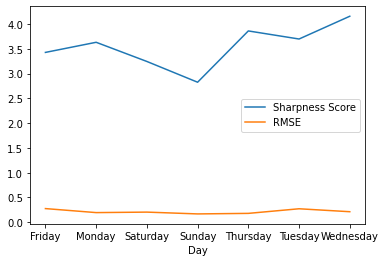

In [78]:
avg_shaprness.plot()

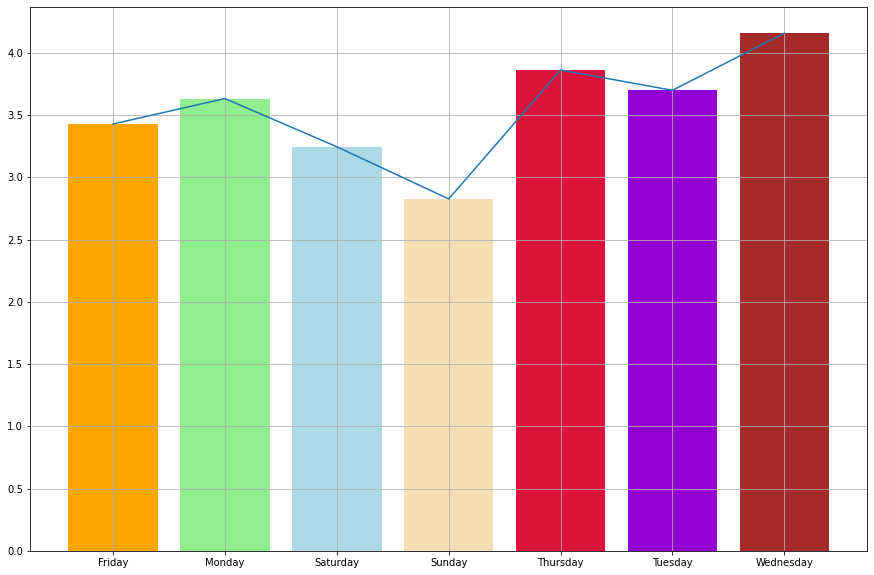

In [79]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.bar(avg_shaprness.index, height=avg_shaprness['Sharpness Score'], color=['Orange', 'LightGreen', 'LightBlue', 'Wheat', 'Crimson', 'DarkViolet', 'Brown'])
ax.plot(avg_shaprness.index, avg_shaprness['Sharpness Score'])
ax.grid()

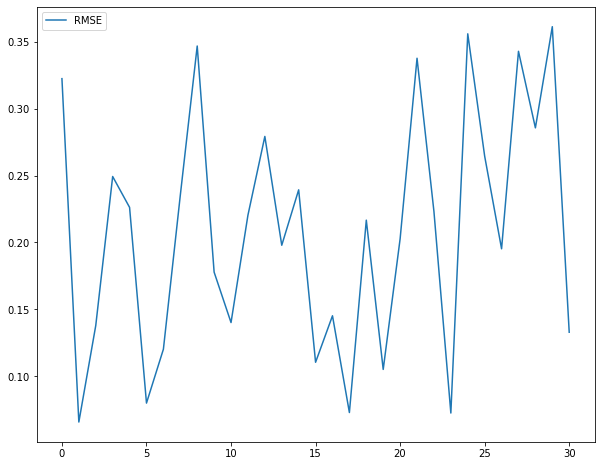

In [61]:
pd.DataFrame(RMSE, columns=['RMSE']).plot(figsize = (10, 8));

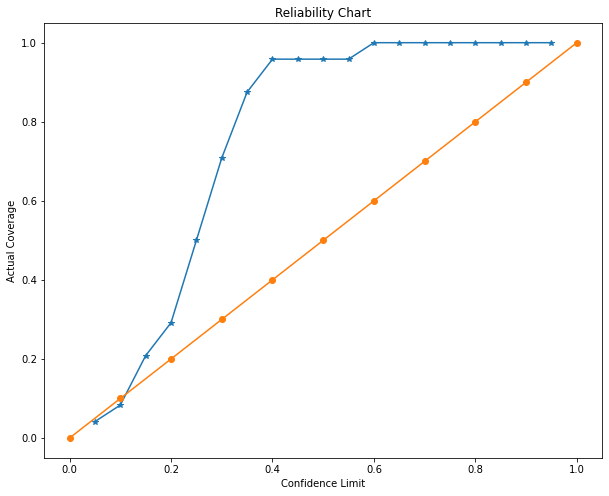

In [62]:
x = []
y = []
for sample in date_coverages[0]:
    x.append(sample[0])
    y.append(sample[1])
    
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(x, y, '-*')
ax.plot(np.arange(0.0,1.1, 0.1), np.arange(0.0,1.1, 0.1), '-o')
ax.set(xlabel='Confidence Limit', ylabel='Actual Coverage', title='Reliability Chart');

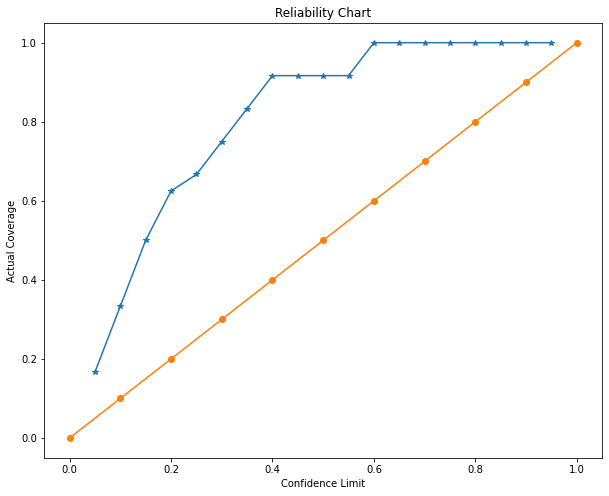

In [63]:
x = []
y = []
for sample in date_coverages[8]:
    x.append(sample[0])
    y.append(sample[1])
    
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(x, y, '*-')
ax.plot(np.arange(0.0,1.1, 0.1), np.arange(0.0,1.1, 0.1), '-o' )
ax.set(xlabel='Confidence Limit', ylabel='Actual Coverage', title='Reliability Chart');